In [1]:
from dataclasses import dataclass
from enum import StrEnum
from datetime import datetime, timedelta
import polars as pl
from collections import defaultdict, Counter
from typing import Tuple
from common.constants.column_types import (
    CPZP_SCHEMA,
    OZP_SCHEMA,
    POHLAVI_CPZP,
    TYP_UDALOSTI,
)
from common.constants.column_names import SHARED_COLUMNS, OZP_COLUMNS, CPZP_COLUMNS
import pickle
from common.constants.objects import (
    Person,
    Gender,
    AgeCohort,
    Prescription,
    PrescriptionType,
)
from common.utils import draw_chart, draw_bar_chart
import matplotlib.pyplot as plt
import numpy as np
import os

pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(60)

polars.config.Config

In [2]:
POJISTOVNA = "cpzp"
with open(f"./DATACON_data/{POJISTOVNA}_persons.pkl", "rb") as f:
    persons: list[Person] = pickle.load(f)

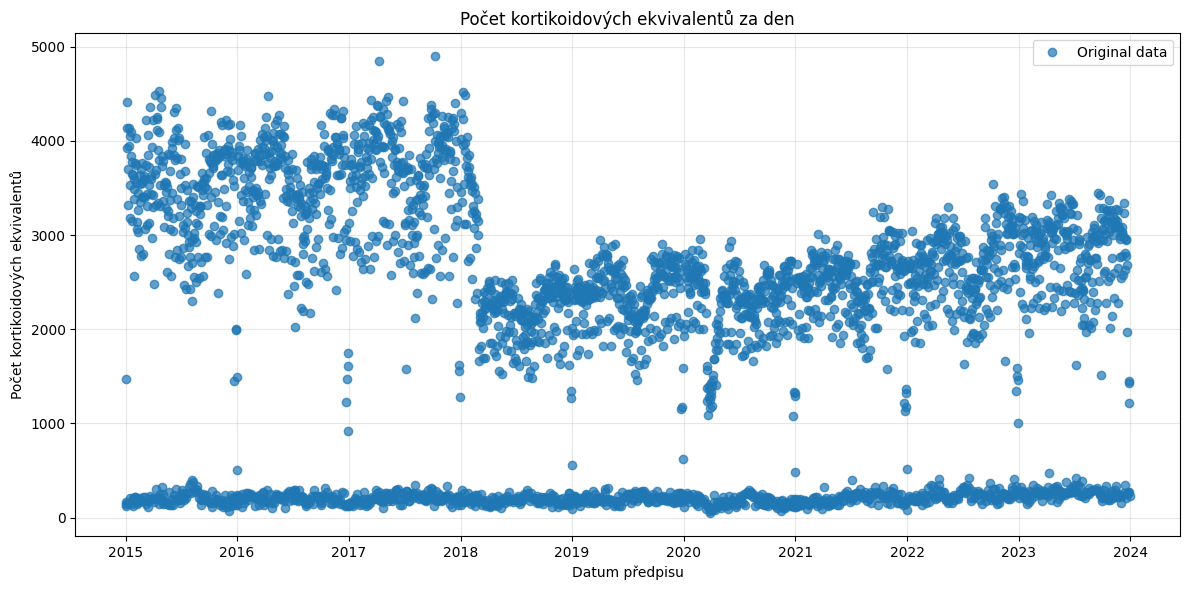

In [8]:
datum_s_kort_ekvivalenty = defaultdict(int)
for person in persons:
    if not person.prescriptions:
        continue
    for prescription in person.prescriptions:
        if prescription.prednison_equiv is None:
            continue
        datum_s_kort_ekvivalenty[prescription.date] += prescription.prednison_equiv

draw_chart(
    mapp=datum_s_kort_ekvivalenty,
    x_label="Datum předpisu",
    y_label="Počet kortikoidových ekvivalentů",
    title="Počet kortikoidových ekvivalentů za den",
    average=False,
)

Sum before 2018: 2701949.25
Sum after 2018: 1800441.5


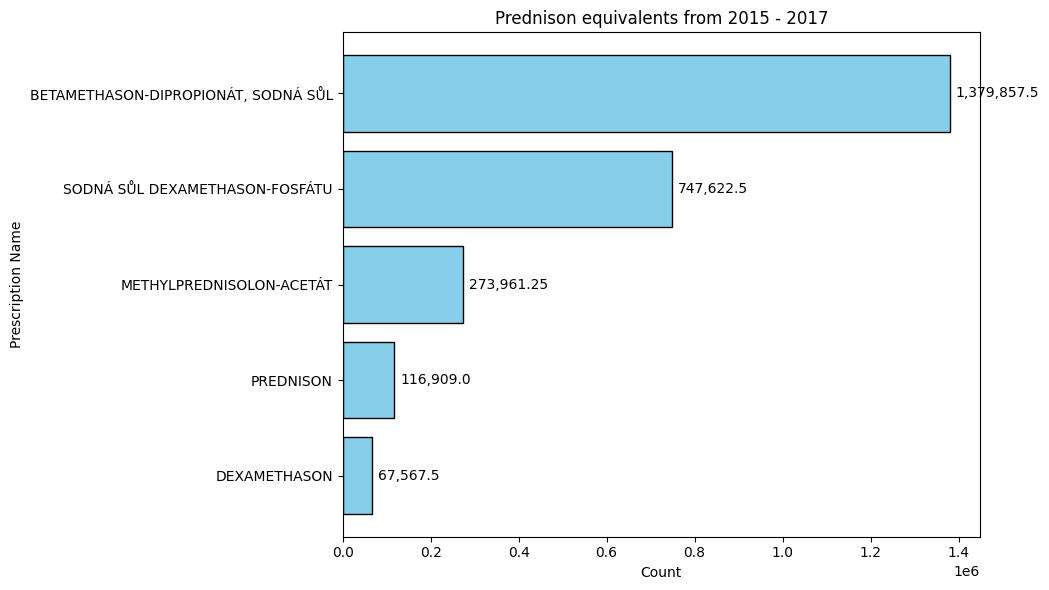

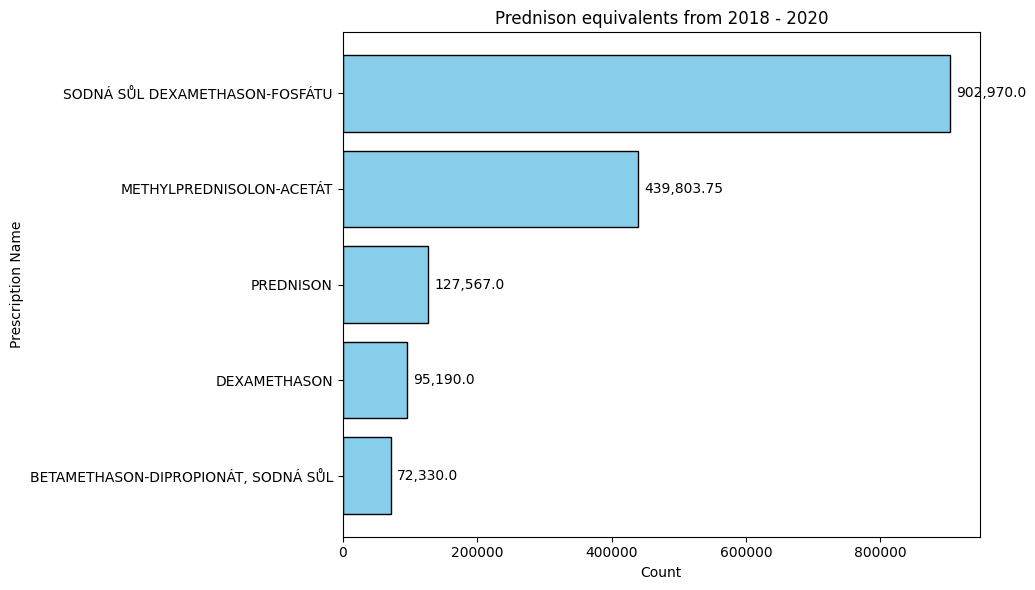

In [14]:
from collections import defaultdict


def draw_top_bar_chart(
    mapp,
    x_label,
    y_label,
    title,
):
    # Sort by value, take top 5, then reverse so biggest is on top
    sorted_items = sorted(mapp.items(), key=lambda item: item[1], reverse=True)[:5]
    sorted_items.reverse()

    y_data = [
        (str(k.value) if hasattr(k, "value") else str(k))[:35] for k, _ in sorted_items
    ]
    x_data = [v for _, v in sorted_items]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(y_data, x_data, color="skyblue", edgecolor="black")

    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.tight_layout()

    # Annotate bars with their values
    for bar, value in zip(bars, x_data):
        plt.text(
            value + max(x_data) * 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{value:,}",
            va="center",
            fontsize=10,
        )

    plt.show()


# --- Data split ---
year_prescription_name_map = defaultdict(lambda: defaultdict(int))

for person in persons:
    for prescription in person.prescriptions:
        if prescription.prednison_equiv is None:
            continue
        year_prescription_name_map[prescription.date.year][
            prescription.latka
        ] += prescription.prednison_equiv

before_2018 = defaultdict(int)
after_2018 = defaultdict(int)

for year in [2015, 2016, 2017]:
    for name, count in year_prescription_name_map[year].items():
        before_2018[name] += count

for year in [2018, 2019, 2020]:
    for name, count in year_prescription_name_map[year].items():
        after_2018[name] += count


sum_before_2018 = sum(before_2018.values())
sum_after_2018 = sum(after_2018.values())
print(f"Sum before 2018: {sum_before_2018}")
print(f"Sum after 2018: {sum_after_2018}")

# --- Charts ---
draw_top_bar_chart(
    before_2018,
    title="Prednison equivalents from 2015 - 2017",
    x_label="Count",
    y_label="Prescription Name",
)

draw_top_bar_chart(
    after_2018,
    title="Prednison equivalents from 2018 - 2020",
    x_label="Count",
    y_label="Prescription Name",
)